In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

df = pd.read_csv("all data/citizen/kerala.csv")

print(df["Species_name"].value_counts())

df = df[df["Species_name"] == "Indian Laburnum-Cassia fistula"]
df = df[df["Year"] == 2023]
df = df.drop(["Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

weeks = df["Week"]
df

Species_name
Mango (all varieties)-Mangifera indica          41613
Jackfruit-Artocarpus heterophyllus              39176
Coconut palm-Cocos nucifera                     14213
Tamarind-Tamarindus indica                      13992
Indian Laburnum-Cassia fistula                  12320
                                                ...  
Broken Bones Tree-Oroxylum Indicum                  1
Chinar-Platanus Orientalis                          1
Duabanga-Duabanga grandiflora                       1
Himalayan Rhododendron-Rhododendron arboreum        1
Khejri-Prosopis cineraria                           1
Name: count, Length: 153, dtype: int64


,Lat,Long,Leaves_fresh,Leaves_mature,Leaves_old,Flowers_bud,Flowers_open,Flowers_male,Flowers_Female,Fruits_unripe,Fruits_ripe,Fruits_open,Week
0,8.77607,76.76274,1.0,2.0,1.0,1.0,1.0,-2.0,-2.0,0.0,1.0,-2.0,31
1,8.81502,76.75704,1.0,2.0,1.0,1.0,1.0,-2.0,-2.0,0.0,1.0,-2.0,31
2,8.81502,76.75704,1.0,2.0,1.0,1.0,1.0,-2.0,-2.0,0.0,1.0,-2.0,31
3,8.81502,76.75704,1.0,2.0,1.0,1.0,1.0,-2.0,-2.0,0.0,1.0,-2.0,31
4,25.24063,73.45485,1.0,2.0,1.0,1.0,1.0,-2.0,-2.0,1.0,1.0,-2.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,11.23439,75.90908,0.0,2.0,2.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,43
2105,10.13036,76.29268,0.0,2.0,1.0,0.0,0.0,-2.0,-2.0,2.0,2.0,-2.0,40
2106,10.13036,76.29268,0.0,2.0,1.0,0.0,0.0,-2.0,-2.0,2.0,2.0,-2.0,39
2107,10.13036,76.29268,0.0,2.0,1.0,0.0,0.0,-2.0,-2.0,2.0,2.0,-2.0,38


In [6]:
data = {}
cent = {}

for week in weeks.unique():
    
    # CLUSTERING
    
    print(f"Week {week}")
    week_df = df[df["Week"] == week]
    
    week_df.drop("Week", axis=1)
    week_df = week_df.reset_index(drop=True)
    
    km = KMeans(n_clusters=1, random_state=42, n_init="auto")
    
    clusters = km.fit_predict(week_df)


    centroids = km.cluster_centers_

    distances = []

    for i, row in week_df.iterrows():
        cluster_label = clusters[i]
        centroid = centroids[0]
        relevant_values = row.values[:len(row.values)]
        float_centroid = [float(val) for val in centroid[:len(centroid)]]
        distance = np.linalg.norm(relevant_values[:len(relevant_values)] - float_centroid)
        distances.append(distance)
    
    #score = silhouette_score(week_df, clusters, metric='euclidean')
    #sil_score.append(score)
        
    #print("Silhouette score: ", score)
        
    # FILTERING
    
    week_df['Distance_to_Centroid'] = distances
    
    std_dev_dist = week_df['Distance_to_Centroid'].std()
    mean = np.mean(week_df["Distance_to_Centroid"])
    
    valid_data = week_df[(week_df['Distance_to_Centroid'] >= mean - 1*std_dev_dist) & (week_df['Distance_to_Centroid'] <= mean + 1*std_dev_dist)]
    
    valid_data = valid_data.reset_index(drop=True)
    clusters2 = km.fit_predict(valid_data)
    
    d = []
    
    centroids = km.cluster_centers_

    for i, row in valid_data.iterrows():
        cluster_label = clusters2[i]
        centroid = centroids[0]
        relevant_values = row.values
        float_centroid = [float(val) for val in centroid]
        distance = np.linalg.norm(relevant_values - float_centroid)
        d.append(distance)
    
    valid_data['Distance_to_Centroid'] = d
    closest_point = valid_data[ valid_data["Distance_to_Centroid"] == min(valid_data['Distance_to_Centroid']) ]
    print(f"Week {week} reference: {closest_point.iloc[0]}")
    cent[week] = km.cluster_centers_
    data[week] = closest_point
    

Week 31
Week 31 reference: Lat                     10.626480
Long                    76.511360
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              1.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week                    31.000000
Distance_to_Centroid     1.542576
Name: 17, dtype: float64
Week 30
Week 30 reference: Lat                      9.14441
Long                    76.61505
Leaves_fresh             1.00000
Leaves_mature            2.00000
Leaves_old               1.00000
Flowers_bud              1.00000
Flowers_open             1.00000
Flowers_male            -2.00000
Flowers_Female          -2.00000
Fruits_unripe            1.00000
Fruits_ripe              0.00000
Fruits_open             -2.00000
Week                    30.00000
Distance_to_Cent

Week 6 reference: Lat                      9.397710
Long                    76.578530
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              1.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                     6.000000
Distance_to_Centroid     1.502776
Name: 24, dtype: float64
Week 0
Week 0 reference: Lat                      8.815020
Long                    76.757040
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              1.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                     0.000000
Distance_to_Ce

31: [[10.23019949 76.26031359  1.          1.97435897  0.69230769  1.25641026
   1.28205128 -2.         -2.          0.82051282  0.48717949 -2.
  31.          2.16824908]]
30: [[ 9.97380735 76.34758367  1.14285714  1.89795918  0.7755102   0.73469388
   0.75510204 -2.         -2.          0.95918367  0.30612245 -2.
  30.          2.12901999]]
34: [[ 9.9255345  76.389889    1.1         1.825       0.875       0.7
   0.725      -2.         -2.          0.85        0.25       -2.
  34.          2.13261582]]
33: [[ 9.68567829 76.5305578   1.12195122  1.87804878  0.53658537  0.80487805
   0.85365854 -2.         -2.          0.82926829  0.2195122  -2.
  33.          2.0620816 ]]
32: [[10.27575891 76.20835709  1.14545455  1.89090909  0.78181818  1.12727273
   1.14545455 -2.         -2.          1.          0.41818182 -2.
  32.          2.19975739]]
35: [[ 9.70236455 76.5219197   1.09090909  1.84848485  0.72727273  0.51515152
   0.51515152 -2.         -2.          0.6969697   0.24242424 -2.
  3

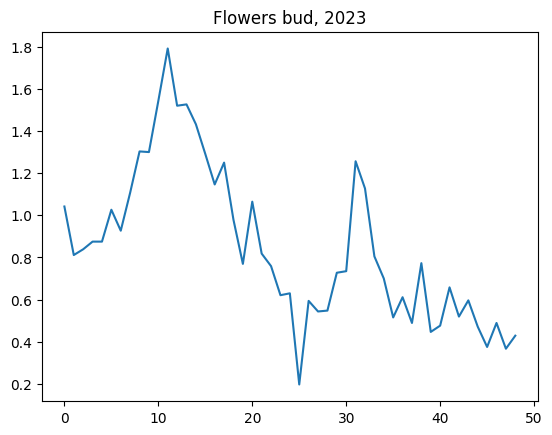

In [10]:
time = np.arange(0, 49)
flowers_bud = []

for key, value in cent.items():
    print(f"{key}: {value}")

for i in range(49):
    flowers_bud.append(cent[i][0][5])
    
    print(f"Observations in week {i}: ", len(df[df["Week"] == i]))


plt.plot(time, flowers_bud)
plt.title("Flowers bud, 2023")
plt.show()